# src_05

This is a rerun of `src/03`, but with a bigger box.

In [38]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [39]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [40]:
# output directory
src_n = 5
dir = f'../data.lbm/0{src_n}/'
# dir = f'../src/0{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

62

# Fluid

In [41]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[20]}.csv").set_index(["id_x","id_y"]).sort_index()

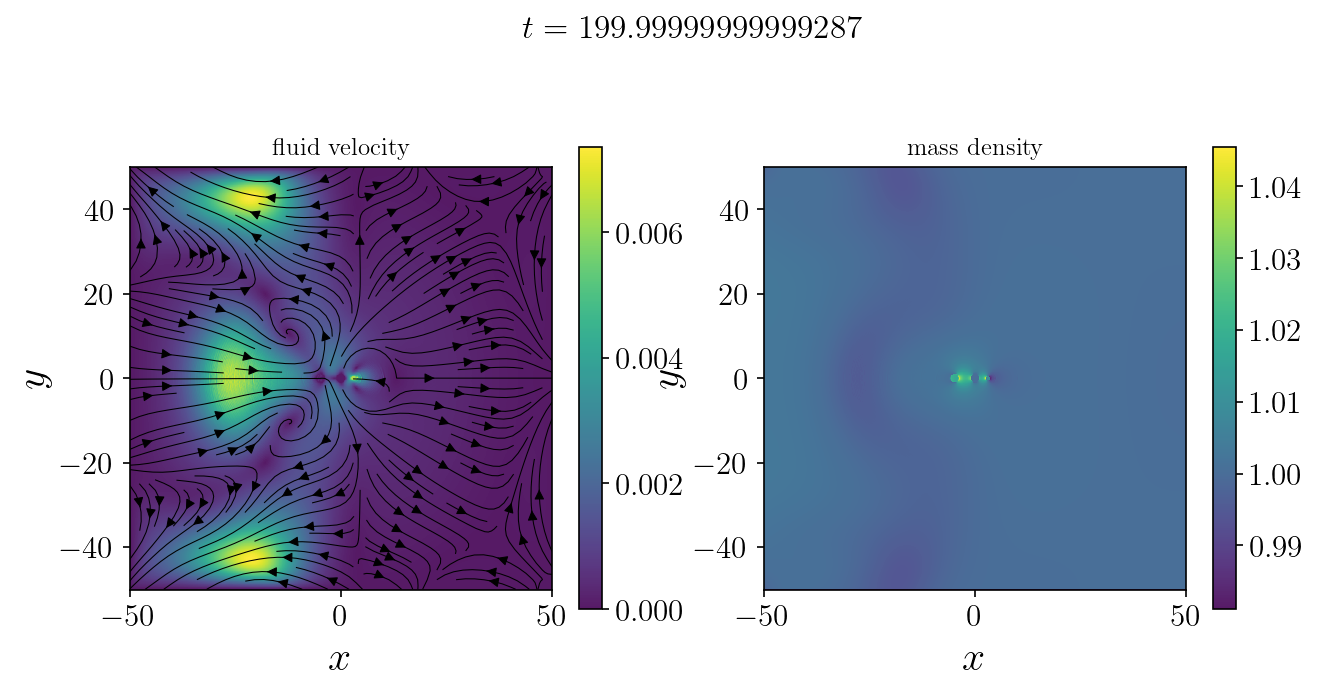

In [42]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

axes[0].streamplot(X, Y, 
    fluidDf.fluidVelocity_x.unstack().values.transpose(),
    fluidDf.fluidVelocity_y.unstack().values.transpose(),
    density=1.5, linewidth=0.5, color="black",
)

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 0").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(len(axes)):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

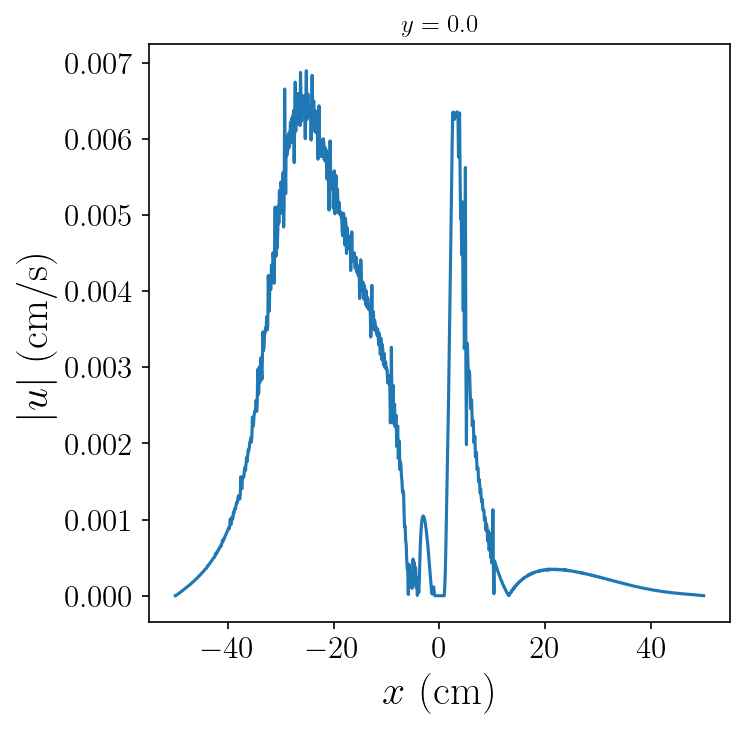

In [43]:
v_x = fluidDf.query("coordinate_y == 0").filter(["coordinate_x", "coordinate_y", "fluidVelocity_x", "fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

# ax.axvline(-2-20, color = "purple", alpha = 0.5)
# ax.axvline(2-20, color = "purple", alpha = 0.5)
# ax.axvspan(-2-20, 2-20, color='purple', alpha=0.25)  # Shade the wall

ax.plot(v_x.coordinate_x, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2), label='LBM') 
ax.set_xlabel("$x$ (cm)")
ax.set_ylabel("$|u|$ (cm/s)")
ax.set_title(f"$y = {v_x.coordinate_y.values[0]}$")
# ax.legend(loc='upper right')

plt.show()

In [44]:
def avgVelocity_X(df):
    return df.fluidVelocity_x.mean()

avgFluidVelocity_X = [
    avgVelocity_X(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

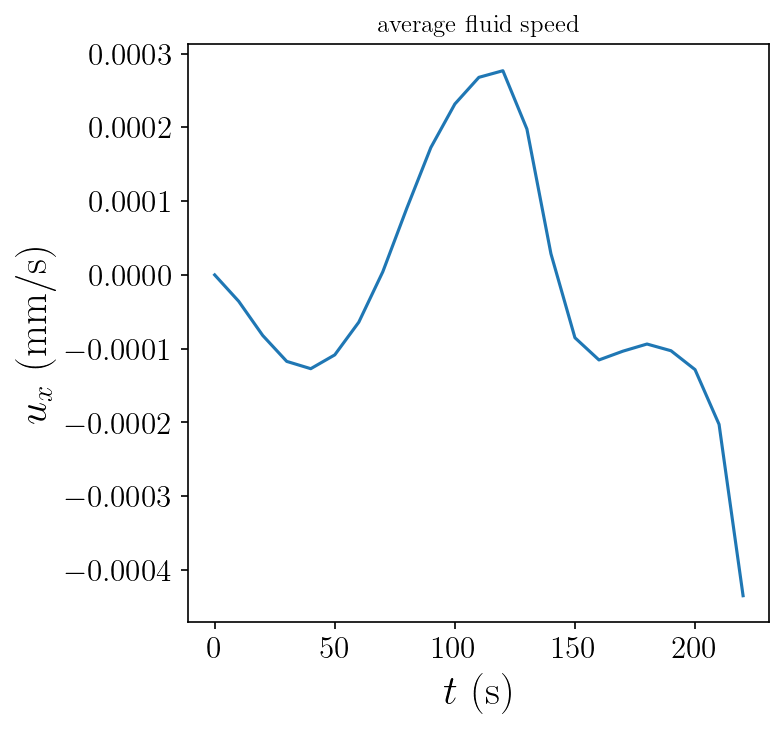

In [49]:
fig, ax = plt.subplots(figsize = (5,5))

lastStableFrame = 23
ax.plot(time[:lastStableFrame], avgFluidVelocity_X[:lastStableFrame])
ax.set_title("average fluid speed")
ax.set_xlabel("$t~(\\mathrm{s})$")
ax.set_ylabel("$u_x$ (mm/s)")

plt.show()

# Stress tensor

In [ ]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

In [ ]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()